# Settling process
Loop till activation settles.

After a winner is found and is processed, clamp down pattern activations in proportion to how similar the patterns are to winner. winner pattern's activation becomes 0.

$a_p = a_p * e^{-||p, w||}$

Where,
- $a_p$ is activation of pattern p
- $w$ is the winner pattern
- $||p,w||$ is distance between pattern $p$ and winner pattern $w$

Now find winner among the updated pattern activations. Repeat till pattern activations settle.

In [0]:
%load_ext autoreload
%autoreload 1

In [23]:
%%writefile hp.py
class HP:
  # Tophat
  # tophat formula derivation https://www.desmos.com/calculator/dnjp9agabt
  width_factor = 500 #3.35        # w
  inhibition_factor = 0.4    # f
  inhibition_scale = 0.2     # i

  # dataset
  image_height = 10
  image_width = 10
  slice_stride = 3
  image_count_root = 100
  image_count = image_count_root * image_count_root

  # patterns
  pattern_count = 20*20
  pattern_size = image_height * image_width
  init_pattern_scale = 0.9
  init_pattern_var = 1

  # similarity
  mask_contrast = 3

  # training
  lr = 1
  settling_steps = 3

Overwriting hp.py


In [24]:
%%writefile tophat.py
import torch
import matplotlib.pyplot as plt
import pdb

class Tophat:
  def __init__(self, hp):
    self.hp = hp

  def __call__(self, x, patterns, winning_pattern):
    d1 = (x.unsqueeze(1) - patterns.unsqueeze(0)).abs()
    d2 = (x - winning_pattern).abs().clamp(min=0.0001).unsqueeze(1)
    d = (d1 - d2).clamp(min=0)
    a = (-d * self.hp.width_factor / d2).mean(dim=-1)
    exc = torch.exp(a)
    inh = torch.exp(a * self.hp.inhibition_factor)

    sim = (exc - self.hp.inhibition_scale * inh) / (1.0 - self.hp.inhibition_scale)
    sim = sim.squeeze()
    return sim

  def show_tophat(self):
    x = torch.linspace(0.0, 1.0, 300)
    sim = self(torch.tensor([0.5]), x.unsqueeze(dim=-1), torch.tensor([0.55]))
    plt.plot(x, sim)
    plt.show()

Overwriting tophat.py


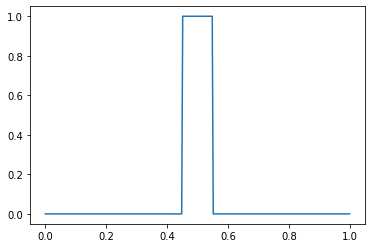

In [25]:
%aimport hp
%aimport tophat

from tophat import Tophat
from hp import HP
Tophat(HP).show_tophat()

In [26]:
%%writefile util.py
import torch
import pdb
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Util:
  @staticmethod
  def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

  @staticmethod
  def norm_scale(t):
    epsilon = 0.00001

    assert len(t.shape)==2, "t shape must be (batch,size)"
    # print("mean", t.mean())
    # print("std", t.std())
    std = t.std(dim=-1).unsqueeze(-1)
    std[std<epsilon] = epsilon
    t = (t - t.mean(dim=-1).unsqueeze(-1)) / std
    # print("max", t.max())
    # print("min", t.min())
    scale = (t.max(dim=-1)[0] - t.min(dim=-1)[0]).unsqueeze(-1)
    scale[scale<epsilon] = epsilon
    t = t / scale

    t = t - t.min(dim=-1)[0].unsqueeze(-1)
    # print("max", t.max())
    # print("min", t.min())

    return t

  @staticmethod
  def convolve(image_width, image_height, kernel_width, kernel_height, stride, max_convolutions):
    convolutions = []
    count = 0
    for x in range(0, image_width - kernel_width + 1, stride):
      for y in range(0, image_height - kernel_height + 1, stride):
        convolutions.append([y, x, y + kernel_height, x + kernel_width])
        count += 1
        if count >= max_convolutions:
          return convolutions

    return convolutions

  @staticmethod
  def conv_slice(images, kernel_width, kernel_height, stride, max_slices):
    image_count, image_height, image_width = images.shape
    convolutions = Util.convolve(image_width, image_height, kernel_width, kernel_height, stride, max_convolutions=max_slices/image_count)
    print("convolutions", len(convolutions))
    slices = [images[i, c[0]:c[2], c[1]:c[3]] for i in range(image_count) for c in convolutions]
  
    slices = torch.stack(slices).float()
    slices = slices.view(slices.shape[0], -1)
    slices = Util.norm_scale(slices)
    slices = slices.to(device)
    return slices

Overwriting util.py


In [27]:
%%writefile graphics_util.py
import matplotlib.pyplot as plt
import numpy as np

class GraphicsUtil:
  @staticmethod
  def show_image_grid(images, vmin=0, vmax=1, w=None, h=None):
    s = images.shape

    assert len(s) == 3
    if w is None or h is None:
      image_grid_size = int(s[0] ** 0.5)
      if image_grid_size > 20:
        return
      w = image_grid_size
      h = image_grid_size
    else:
      assert w * h == s[0]

    if w == 1 and h == 1:
      plt.figure(figsize=(h, w))
      plt.axis("off")
      plt.imshow(images[0].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis, aspect='auto')
    else:
      fig, axs = plt.subplots(nrows=h, ncols=w, figsize=(w*0.5, h*0.5),
                            subplot_kw={'xticks': [], 'yticks': []})

      
      axs = axs.flat
      for i in np.arange(s[0]):
        axs[i].axis("off")
        axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis, aspect='auto')
        
      fig.subplots_adjust(top=1, left=0, bottom=0, right=1, wspace=0.1, hspace=0.1)

    plt.show()


Overwriting graphics_util.py


In [28]:
%%writefile dataset_loader.py
from util import Util
from graphics_util import GraphicsUtil

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_cifar10(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_imagefolder(batch_size=64):
  loader = torch.utils.data.DataLoader(
      datasets.ImageFolder('/content/drive/My Drive/work/datasets/pattern',
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)
  
  return loader

def load_dataset(hp, batch_size=1000):
  images = next(iter(load_imagefolder(batch_size=1)))[0]
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  images = images[:,0,:,:].unsqueeze(1)
  ib, ic, ih, iw = images.shape
  print("images", images.shape)
  images = images.view(ib*ic, ih, iw)
  print("images", images.shape)

  plt.imshow(images[0], vmin=0, vmax=1)
  plt.show()

  dataset = Util.conv_slice(images, kernel_width=hp.image_width, kernel_height=hp.image_height, stride=hp.slice_stride, max_slices=hp.image_count)
  GraphicsUtil.show_image_grid(dataset.view(-1, hp.image_height, hp.image_width))

  offset = 0
  dataset = torch.utils.data.TensorDataset(dataset[offset:offset+hp.image_count])
  
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, pin_memory=False)
  return loader

Overwriting dataset_loader.py


In [29]:
%%writefile pattern_memory_layer.py
from util import Util
from graphics_util import GraphicsUtil
from tophat import Tophat

import matplotlib.pyplot as plt
import torch
import pdb
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class PatternMemoryLayer(torch.nn.Module):
  def __init__(self, hp):
    super().__init__()
    self.hp = hp
    self.tophat = Tophat(hp)

    self.patterns = torch.rand((self.hp.pattern_count, self.hp.pattern_size)).to(device) * self.hp.init_pattern_scale
    # self.patterns = torch.ones((self.hp.pattern_count, self.hp.pattern_size)).to(device)
    self.pattern_lr = torch.ones((self.patterns.shape[0],)).to(device) * 1.0
    self.pattern_var = torch.ones_like(self.patterns).to(device) * self.hp.init_pattern_var

    self.original_patterns = self.patterns.clone().to(device)
    GraphicsUtil.show_image_grid(self.patterns.view(-1, self.hp.image_height, self.hp.image_width))

  def forward(self, x):
    # print("pattern_var", pattern_var)
    batch_size = x.shape[0]
    # print("batch_size", batch_size)
    winner_indices = []

    sim, winner_index, dist, dist_i = self.similarity(x=x, x_precision=None)
    sim = sim.unsqueeze(-1)
    # print("--winner_index", winner_index.shape)
    # print("x", x)
    # print("sim, winner_index, dist, dist_i", sim, winner_index, dist, dist_i)
    for settling_step in range(self.hp.settling_steps):
      for i in range(batch_size):
        wi = winner_index[i]
        self.pattern_lr[wi] = 0.9 * self.pattern_lr[wi] + 0.1 * (1.0 - torch.exp(-dist[i, wi]))
        self.pattern_var[wi] = 0.9 * self.pattern_var[wi] + 0.1 * dist_i[i, wi, :]

        delta = (x[i] - self.patterns) * sim[i] * self.hp.lr * self.pattern_lr.unsqueeze(-1)
        self.patterns = self.patterns + delta

        # subtract winning pattern from input to find secondary, tertiary, etc principal components
        x[i] = (x[i] - self.patterns[wi] * self.pattern_var[wi]).clamp_(0, 1)
    
      # x = Util.norm_scale(x)

      # print("WINNERS: ", torch.bincount(wi))
      self.patterns.clamp_(0, 1)
      self.pattern_lr.clamp(0, 1)
        

  def precision_weighted_distance(self, x, x_precision):
    mask = torch.exp(-self.pattern_var * self.hp.mask_contrast) # *3 so that var of 1 gives low enough mask value ~0.5. Thus mask range [0.5,1]
    dist_i = (x.unsqueeze(1) - self.patterns.unsqueeze(0)).abs()    
    # print("dist_i.sum(dim=-1)", dist_i.sum(dim=-1))
    # print("pattern_lr", pattern_lr)
    dist_i = dist_i * torch.exp(-self.pattern_lr*0.8).unsqueeze(-1) # mature patterns want to be winners for very specific patterns.
    # print("dist_i.sum(dim=-1)", dist_i.sum(dim=-1))
    di = (dist_i ** 2) * mask  # distance weighted by importance
    if x_precision is not None:
      di = di * x_precision.unsqueeze(1)
    # print("di.sum(dim=-1)", di.sum(dim=-1))
    # print("mask.sum(dim=-1)", mask.sum(dim=-1))
    dist = di.sum(dim=-1) / mask.sum(dim=-1) # dividing by mask sum ~= count of # of dims the pattern cares about
    return dist, dist_i

  def similarity(self, x, x_precision):
    # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
    # print("x", x)
    # print("patterns", patterns)
    dist, dist_i = self.precision_weighted_distance(x, x_precision)
    # print("dist", dist)
    winner_index = dist.min(dim=-1)[1]

    winning_pattern = self.patterns[winner_index]
    # print("winning_pattern", winning_pattern)

    sim = self.tophat(x, self.patterns, winning_pattern)

    # print("sim", sim)

    return sim, winner_index, dist, dist_i

  def autoassociative_recall(self, x, x_precision):
    # pdb.set_trace()
    dist, _ = self.precision_weighted_distance(x, x_precision)
    sim = torch.exp(-dist*100) * (1.0 - self.pattern_lr.unsqueeze(0))
    mask = torch.exp(-self.pattern_var * self.hp.mask_contrast)
    masked_patterns = self.patterns * mask
    y = (sim.mm(masked_patterns) / sim.sum(-1).unsqueeze(-1))
    y = Util.norm_scale(y)
    return y

  def predict(self, dataset, dataset_precision):
    loss = 0.0
    output = []
    # pdb.set_trace()
    dataset = dataset.dataset.tensors[0]

    for i in range(dataset.shape[0]):
      x = dataset[i]
      if dataset_precision is not None:
        x_precision = dataset_precision[i]
      else:
        x_precision = None
      y = self.autoassociative_recall(x.unsqueeze(0), x_precision)
      output.append(y)
      loss += torch.dist(x, y)

    output = torch.stack(output)
    # plot_patterns(output, pattern_lr=None, dataset=original_dataset, voronoi=False, annotate=False, figsize=(12,12))
    print("loss", loss)
    return output, loss



Overwriting pattern_memory_layer.py


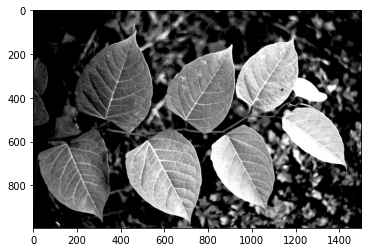

images torch.Size([1, 1, 994, 1500])
images torch.Size([1, 994, 1500])


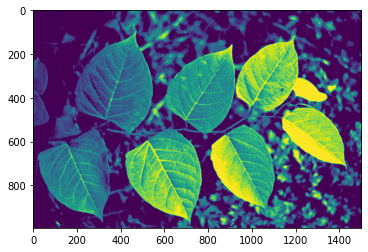

convolutions 10000


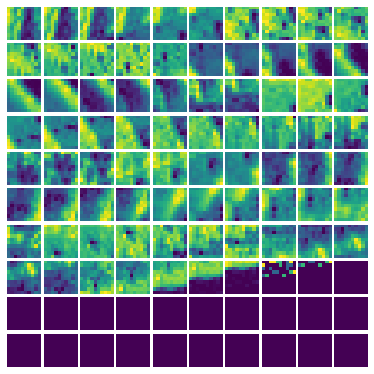

In [30]:
%aimport hp
%aimport tophat
%aimport util
%aimport graphics_util
%aimport dataset_loader
%aimport pattern_memory_layer

from hp import HP
from dataset_loader import load_dataset
from graphics_util import GraphicsUtil

original_dataset = dataset_loader.load_dataset(HP, batch_size=100000)
GraphicsUtil.show_image_grid(original_dataset.dataset.tensors[0][100:200].view(-1, HP.image_height, HP.image_width), vmin=0, vmax=1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


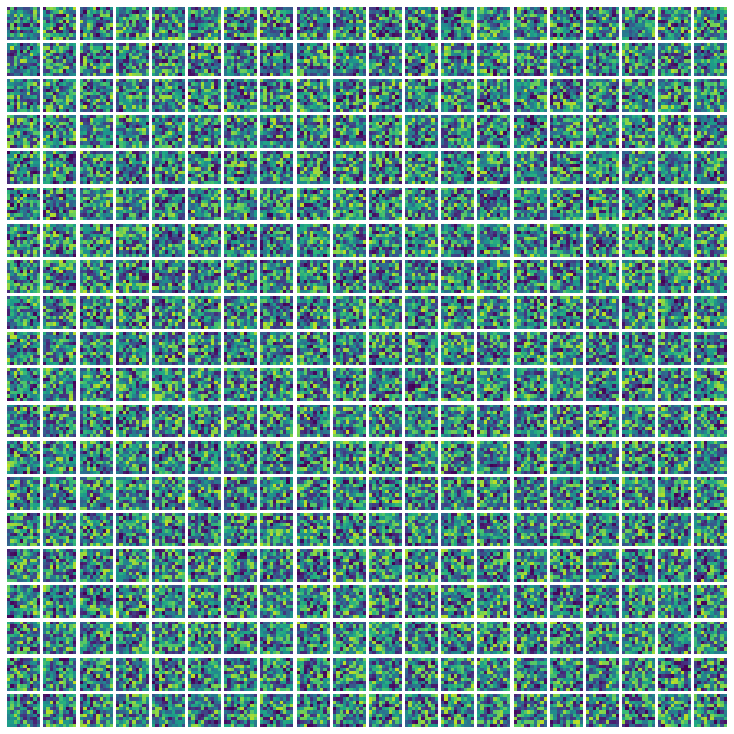

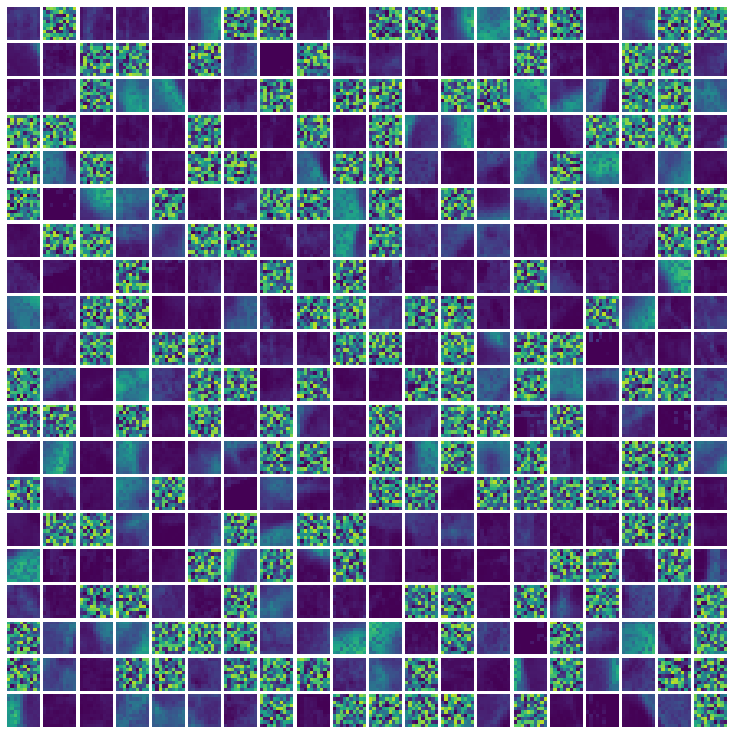

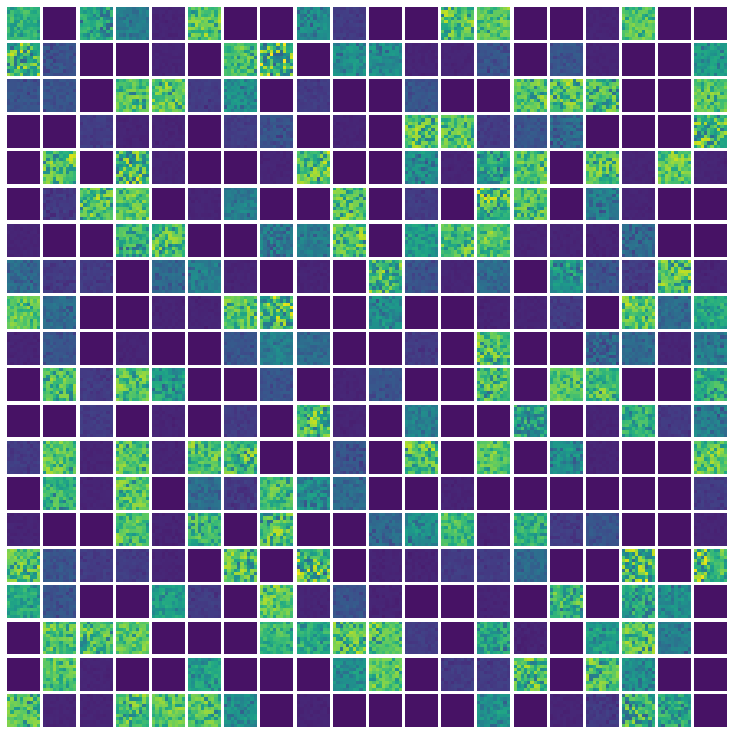

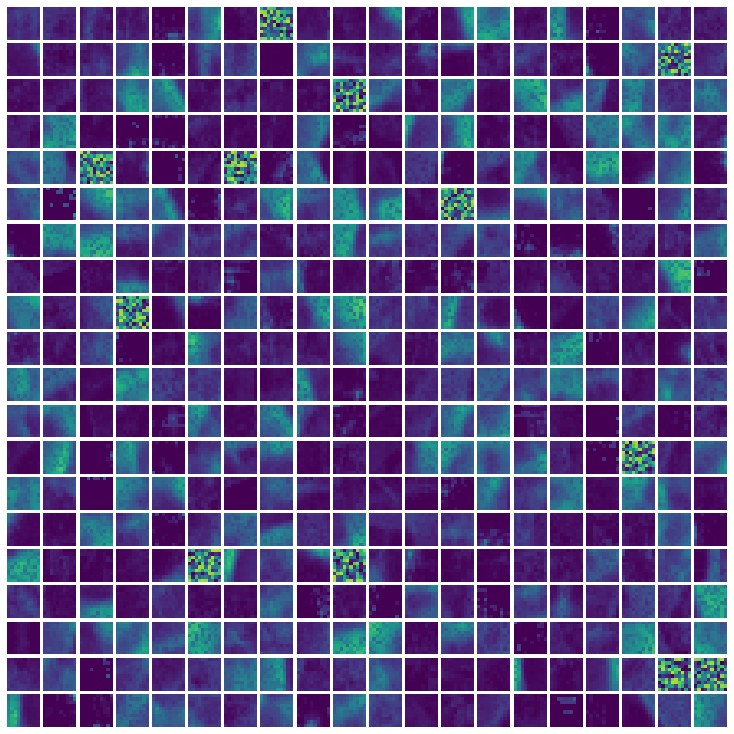

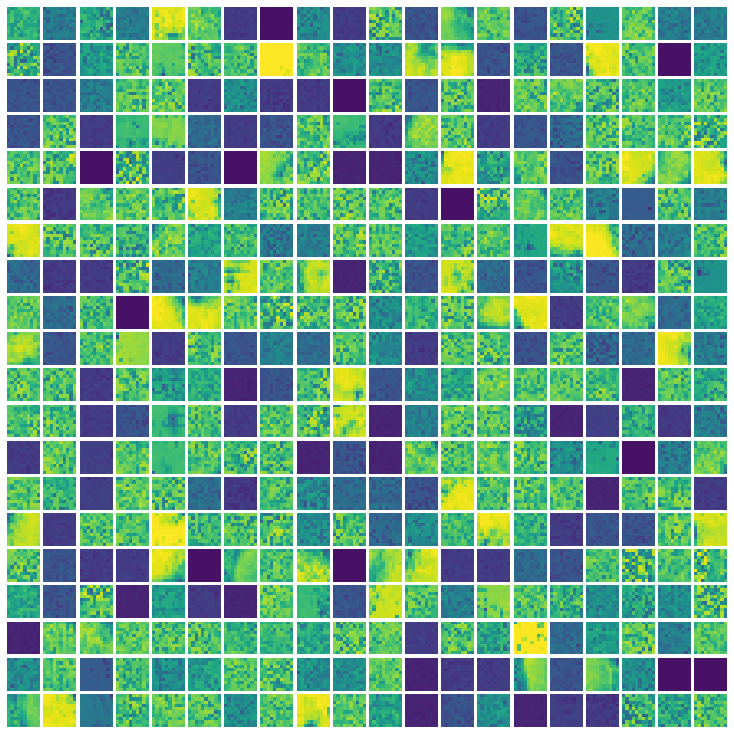

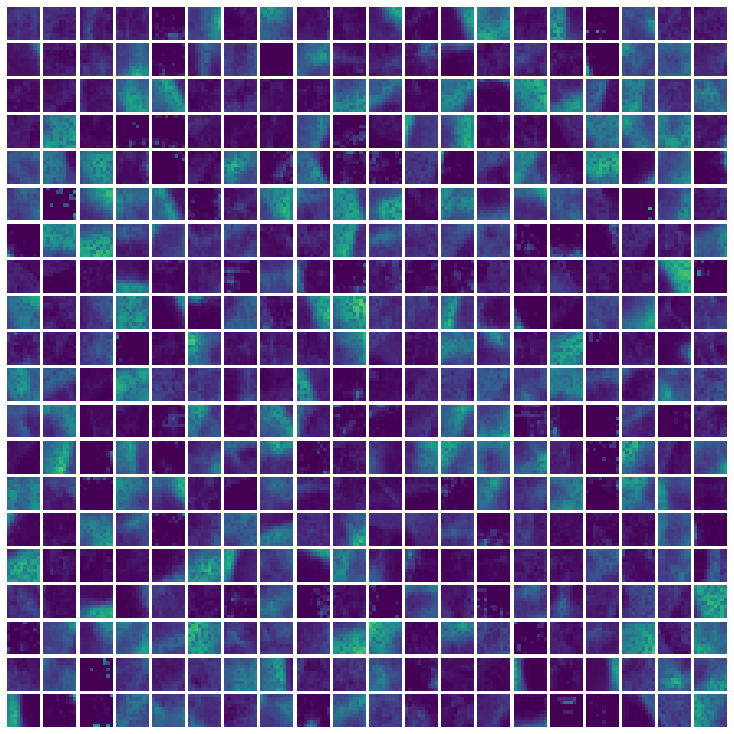

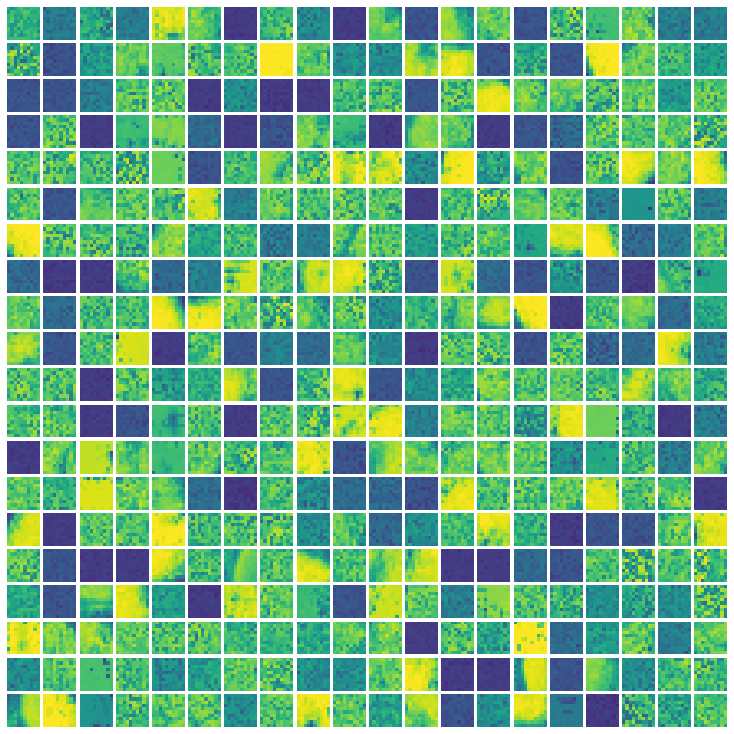

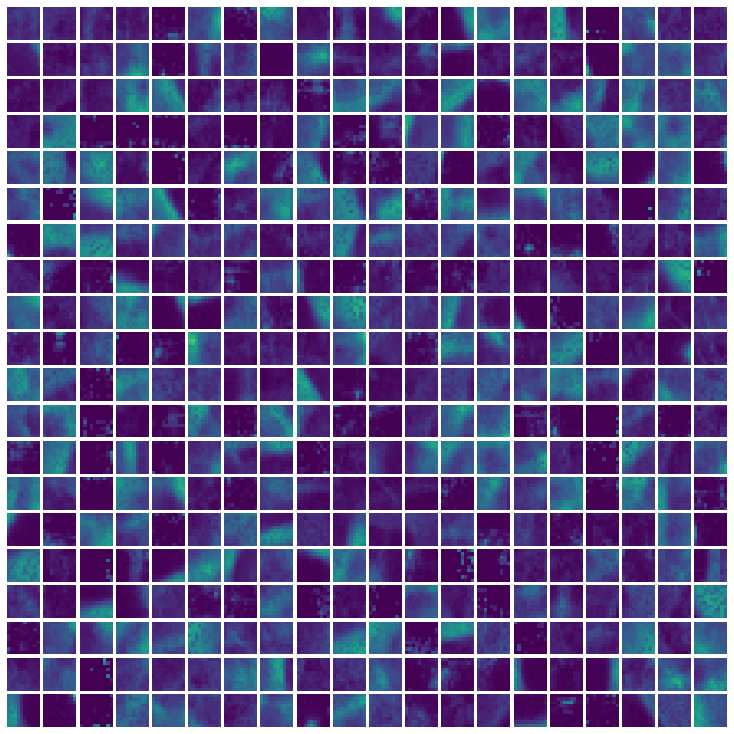

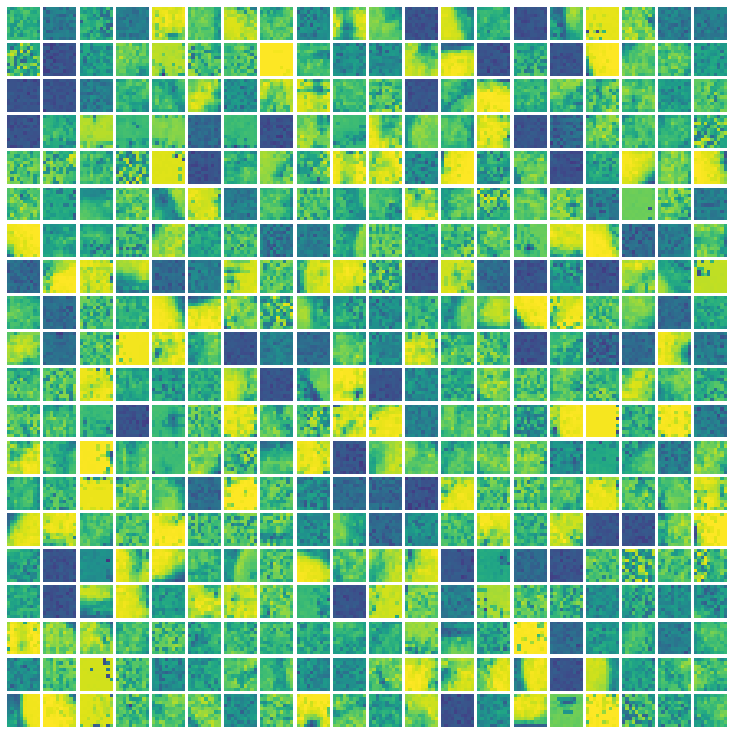

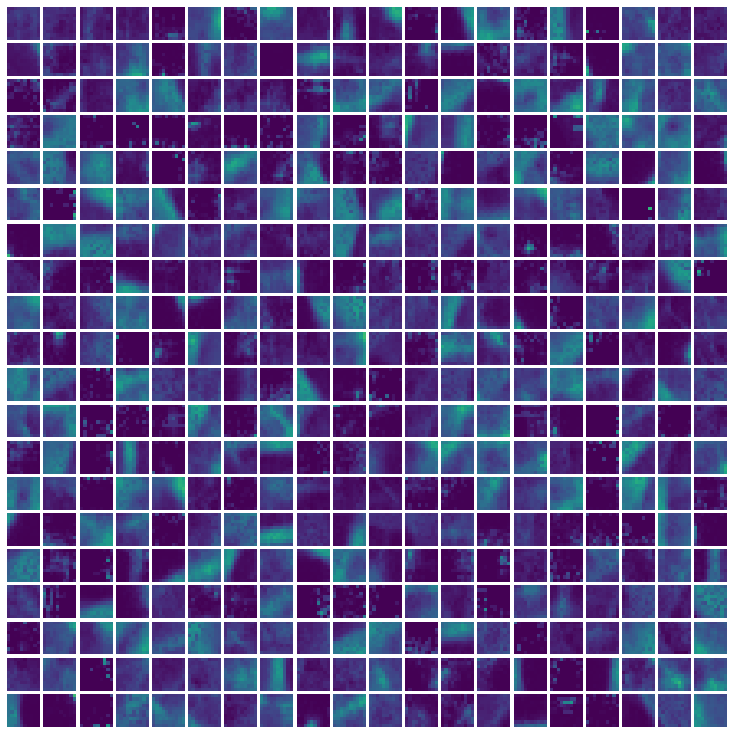

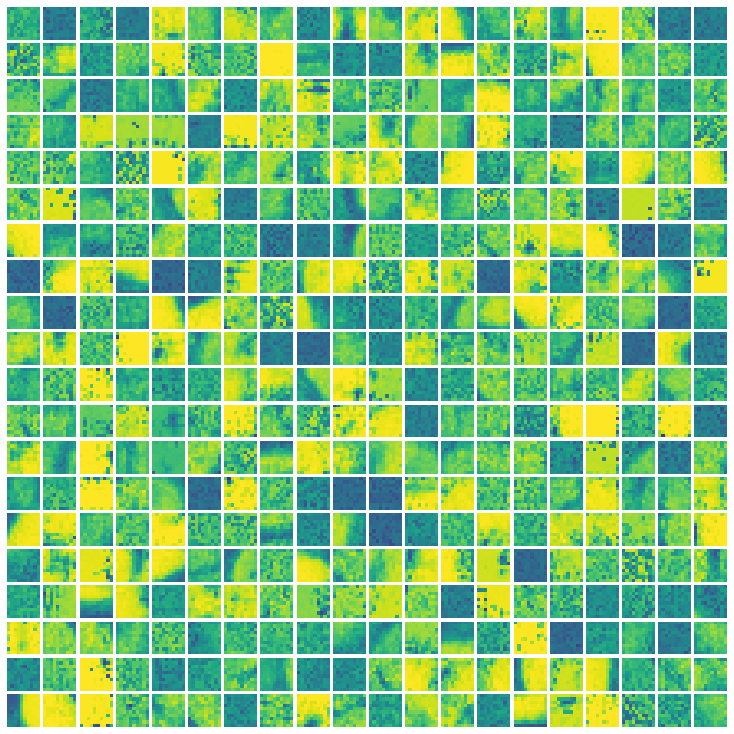

In [31]:
!pip install line_profiler
%load_ext line_profiler

from hp import HP
from pattern_memory_layer import PatternMemoryLayer
from util import Util
from graphics_util import GraphicsUtil
import torch
import pdb

layer1 = PatternMemoryLayer(HP)

def run(epochs=8):
  dataset_precision = None

  # layer1.predict(original_dataset, dataset_precision)
  for i in range(epochs):
    # dataset = Util.add_gaussian_noise(original_dataset, std=noise)

    for batch in iter(original_dataset):
      layer1(batch[0])

    # layer1.predict(original_dataset, dataset_precision)

    if True: #(i+1) % int(epochs / 5) == 0:
      GraphicsUtil.show_image_grid(layer1.patterns.view(-1, HP.image_height, HP.image_width))
      GraphicsUtil.show_image_grid(torch.exp(-layer1.pattern_var.view(-1, HP.image_height, HP.image_width) * HP.mask_contrast))
      # GraphicsUtil.show_image_grid(dataset.view(-1, HP.image_height, HP.image_width))

# %lprun -f run -m pattern_memory_layer run(epochs=5)
run(epochs=5)

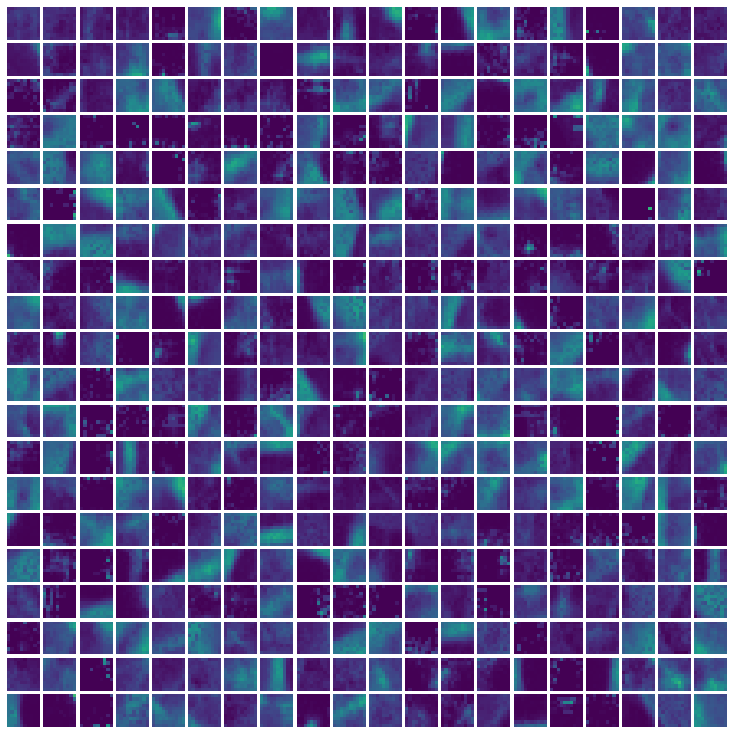

patch, prediction, winning pattern


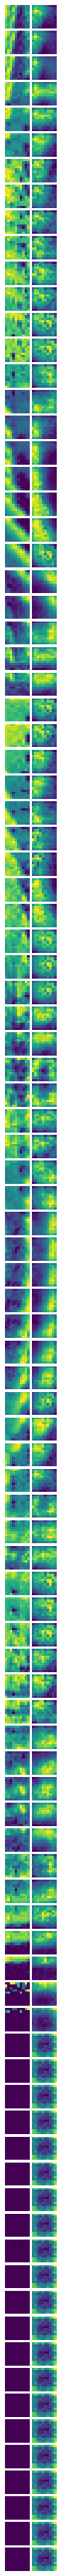

In [32]:
GraphicsUtil.show_image_grid(layer1.patterns.view(-1, HP.image_height, HP.image_width))

# for i in range(100, 120):
#   print("Patch", i)
#   x = dataset[i]
#   show_image_grid(x.view(HP.image_height, HP.image_width).unsqueeze(0))
#   plt.show()

result_images = []
test_images = original_dataset.dataset.tensors[0][100:200]
result = layer1.autoassociative_recall(test_images, None)
# pdb.set_trace()

for i in range(test_images.shape[0]):
  # print("Patch", i)
  result_images_row = []

  x = test_images[i]

  result_images_row.append(x.view(HP.image_height, HP.image_width))
  result_images_row.append(result[i].view(HP.image_height, HP.image_width))

  # sim, winner_index, dist, dist_i = layer1.similarity(x=x, x_precision=None)
  # winning_pattern = layer1.patterns[winner_index]
  # result_images_row.append(winning_pattern.view(HP.image_height, HP.image_width))

  result_images.append(torch.stack(result_images_row))

print("patch, prediction, winning pattern")
result_images = torch.stack(result_images)
h, w, ih, iw = result_images.shape
GraphicsUtil.show_image_grid(result_images.view(-1, ih, iw), h=h, w=w)


Settling steps introduce noise in the patterns. That results in poor results from autoassociative_recall. As a result, HP.settling_steps = 1, i.e. no additional setting steps, is the best choice.